# Import & Config

In [2]:
!pip install hazm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 89.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 95.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 45.7 MB/s eta 0:00:00:00:0100:01
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9296 sha256=23180b814a18a572965be15849bf5baf03f873e48aa7155fdccbd5c514e3ff9f
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstal

In [3]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable

import string
import re

# Additional imports
import hazm  # For Persian text normalization and lemmatization
import os
import zipfile
import matplotlib.pyplot as plt


In [4]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()
device = torch.device('cuda' if train_on_gpu else 'cpu')
if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')

print(torch.__version__)

CUDA is available! Training on GPU ...
2.4.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data

In [ ]:
#-------------------------------------------------------------------#

## Download dataset from Kaggle

In [4]:
# Install Kaggle and set up credentials
!pip install kaggle
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download datasets
!kaggle datasets download miladfa7/persian-wikipedia-dataset -f Persian-WikiText-1.txt
!kaggle datasets download alioraji/persian-stop-words -f Persian_Stop_Words.txt

# Unzip datasets
with zipfile.ZipFile('Persian-WikiText-1.txt.zip', 'r') as zip_ref:
    zip_ref.extractall()


cp: cannot stat './kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/miladfa7/persian-wikipedia-dataset
License(s): CC0-1.0
 18%|██████▉                               | 5.00M/27.5M [00:00<00:00, 41.1MB/s]
100%|███████████████████████████████████████| 27.5M/27.5M [00:00<00:00, 145MB/s]
Dataset URL: https://www.kaggle.com/datasets/alioraji/persian-stop-words
License(s): other
  0%|                                               | 0.00/45.5k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 45.5k/45.5k [00:00<00:00, 14.7MB/s]


## Data Preprocessing

# Data Preprocessing



In this section, we will preprocess the Persian Wikipedia dataset to prepare it for training the RNN model. The preprocessing steps include:



1. **Loading the Dataset**: Read the raw text data.

2. **Cleaning the Text**: Remove noise such as special characters, numbers, and punctuation.

3. **Removing Stop Words**: Eliminate common words that do not contribute significantly to the meaning.

4. **Lemmatization**: Reduce words to their base or dictionary form.

5. **Tokenization**: Split text into tokens using Byte Pair Encoding (BPE).



Each step is crucial for enhancing the quality of the data and improving the model's performance.


In [5]:
# Load the Persian Wikipedia text data
with open('Persian-WikiText-1.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# Load Persian stop words
with open('Persian_Stop_Words.txt', 'r', encoding='utf-8') as file:
    stop_words = file.read().splitlines()

print(f"Total number of characters in the dataset: {len(text)}")


Total number of characters in the dataset: 56695909


In [6]:
# Initialize Hazm Normalizer and Lemmatizer
normalizer = hazm.Normalizer()
lemmatizer = hazm.Lemmatizer()

# Normalize the text
normalized_text = normalizer.normalize(text)
print(f"First 500 characters after normalization:\n{normalized_text[:500]}")

# Tokenize the text into words
tokens = hazm.word_tokenize(normalized_text)
print(f"Number of tokens after tokenization: {len(tokens)}")
print(f"First 10 tokens: {tokens[:10]}")

# Remove stop words, punctuation, and digits
filtered_tokens = []
for token in tokens:
    if (token not in stop_words) and (token not in string.punctuation) and (not token.isdigit()):
        filtered_tokens.append(token)

print(f"Number of tokens after removing stop words, punctuation, and digits: {len(filtered_tokens)}")
print(f"First 10 tokens after removal: {filtered_tokens[:10]}")

# Ensure no empty tokens are present
non_empty_tokens = [token for token in filtered_tokens if token.strip() != '']
print(f"Number of tokens after removing empty tokens: {len(non_empty_tokens)}")
print(f"First 10 tokens after removing empty tokens: {non_empty_tokens[:10]}")

# Lemmatize tokens
lemmatized_tokens = []
for token in non_empty_tokens:
    lemmatized = lemmatizer.lemmatize(token)
    if lemmatized and lemmatized.strip() != '':
        lemmatized_tokens.append(lemmatized)

print(f"Total number of tokens after lemmatization: {len(lemmatized_tokens)}")
print(f"First 10 lemmatized tokens: {lemmatized_tokens[:10]}")

# Final check to ensure no empty tokens
final_tokens = [token for token in lemmatized_tokens if token.strip() != '']
print(f"Total number of tokens after final empty token removal: {len(final_tokens)}")
print(f"First 10 tokens after final removal: {final_tokens[:10]}")

# Write the preprocessed text to a file for SentencePiece training
preprocessed_text = ' '.join(final_tokens)


First 500 characters after normalization:
عنوان مقاله: صفحه اصلی

<templatestyles src= " صفحه اصلی /

عنوان مقاله: ویکی پدیا

ویکی پدیا (کوته نوشت به صورت «وپ» و «WP») یک دانشنامه برخط چندزبانه مبتنی بر وب با محتوای آزاد و همکاری باز است که با همکاری افراد داوطلب نوشته می‌شود و هر کسی که به اینترنت و وب دسترسی داشته باشد می‌تواند مقالات آن را ببیند و ویرایش کند. نام ویکی پدیا واژه‌ای ترکیبی است که از واژه‌های ویکی (وبگاه مشارکتی) و انسایکلوپدیا (Encyclopedia) (دانشنامه یا دائرةالمعارف) گرفته‌شده است. هدف ویکی پدیا آفرینش و انتشار جهانی 
Number of tokens after tokenization: 11889414
First 10 tokens: ['عنوان', 'مقاله', ':', 'صفحه', 'اصلی', '<templatestyles', 'src=', '"', 'صفحه', 'اصلی']
Number of tokens after removing stop words, punctuation, and digits: 5470186
First 10 tokens after removal: ['مقاله', 'صفحه', 'اصلی', '<templatestyles', 'src=', 'صفحه', 'اصلی', 'مقاله', 'ویکی', 'پدیا']
Number of tokens after removing empty tokens: 5470184
First 10 tokens after removing empty tokens: ['مقا

### Why Remove Stop Words and Noise?



**Stop Words Removal**:

- **Purpose**: Stop words are common words that carry minimal semantic meaning (e.g., "and", "the" in English).

- **Advantage**: Removing them reduces the dimensionality of the data, speeds up training, and often improves model performance by focusing on more meaningful words.



**Removing Noise**:

- **Purpose**: Noise includes special characters, numbers, and irrelevant punctuation that do not contribute to the language modeling task.

- **Advantage**: Cleaning the data helps in creating a more consistent and meaningful vocabulary, which enhances the model's ability to learn patterns.



**Other Removals**:

- **Single-character Words**: Often do not carry significant meaning and can be removed to reduce noise further.

- **Reason**: Helps in focusing the model on more substantial words, improving the quality of the learned representations.


### Lemmatization with Hazm



**Lemmatization**:

- **Definition**: Lemmatization is the process of reducing words to their base or dictionary form (lemma).

  

**Advantages**:

1. **Reduces Vocabulary Size**: By converting different forms of a word to a single lemma, it decreases the number of unique tokens.

2. **Improves Model Generalization**: Models can better generalize patterns across different forms of the same word.

3. **Enhances Consistency**: Ensures that variations of a word are treated uniformly, improving the learning process.



Using the **Hazm** library, which is specifically designed for Persian language processing, we can effectively perform lemmatization to prepare our dataset for training.


### Tokenization with Byte Pair Encoding (BPE)



**Byte Pair Encoding (BPE)**:

- **Mechanism**: BPE is a subword tokenization algorithm that iteratively merges the most frequent pair of characters or subwords in the text to form a new token. This process continues until a predefined vocabulary size is reached.

  

**Advantages**:

1. **Handles Out-of-Vocabulary Words**: By breaking words into subwords, BPE can effectively manage rare or unseen words during training.

2. **Balances Granularity**: Provides a balance between character-level and word-level tokenization, capturing meaningful subword units.

3. **Reduces Vocabulary Size**: Helps in maintaining a manageable vocabulary size, which is crucial for training efficiency.



**Disadvantages**:

1. **Subword Fragmentation**: Words might be split into multiple subwords, which can sometimes hinder understanding of complete word meanings.

2. **Requires Preprocessing**: Needs an additional step to learn and apply the BPE merges, which adds complexity to the preprocessing pipeline.

  

Using BPE allows our model to handle the rich morphology of the Persian language more effectively, ensuring better performance in text generation tasks.


### BPE Tokenization

In [5]:
# Load the Persian Wikipedia text data
with open('Persian-WikiText-1.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# Verify the text content
print(f"Total number of characters in the dataset: {len(text)}")
print(f"First 500 characters:\n{text[:500]}")


Total number of characters in the dataset: 56695909
First 500 characters:
عنوان مقاله: صفحهٔ اصلی

<templatestyles src="صفحه اصلی/



عنوان مقاله: ویکی پدیا

ویکی پدیا (کوته نوشت به صورت «وپ» و «WP») یک دانشنامه برخط چندزبانه مبتنی بر وب با محتوای آزاد و همکاری باز است که با همکاری افراد داوطلب نوشته می شود و هر کسی که به اینترنت و وب دسترسی داشته باشد می تواند مقالات آن را ببیند و ویرایش کند. نام ویکی پدیا واژه ای ترکیبی است که از واژه های ویکی (وبگاه مشارکتی) و اِنسایکلوپدیا (Encyclopedia) (دانشنامه یا دائرةالمعارف) گرفته شده است. هدف ویکی پدیا آفرینش و انتشار جهانی


In [ ]:
# final_tokens
print(len(final_tokens))
print(final_tokens[:10])
print(type(preprocessed_text))
# empt = 0
# cntr = 0
# for i in preprocessed_text:
#     cntr += 1
#     if i.strip() == "":
#         empt += 1
#         # print("Empty sentence!")
# print("Empty counter: "+str(empt))
# print("counter: "+str(cntr))

In [7]:
# Write the preprocessed text to a file for SentencePiece training
preprocessed_text = '\n'.join(final_tokens)

In [ ]:
print(len(preprocessed_text))

empt = 0
cntr = 0

for i in preprocessed_text:
    cntr += 1
    if i.strip() == "":
        empt += 1
        # print("Empty sentence!")
print("Empty counter: "+str(empt))
print("counter: "+str(cntr))

In [5]:
# Install SentencePiece for BPE
!pip install sentencepiece

import sentencepiece as spm

# Additional check: Ensure that the preprocessed text is not empty
if (not os.path.exists('preprocessed_text.txt')):
    if len(preprocessed_text.strip()) == 0:
        print("Error: Preprocessed text is empty. Please check the preprocessing steps.")
    else:
        with open('preprocessed_text.txt', 'w', encoding='utf-8') as file:
            file.write(preprocessed_text)
        print(f"Successfully wrote preprocessed text to 'preprocessed_text.txt'. Total characters: {len(preprocessed_text)}")
else:
    # Load the Persian Wikipedia text data
    with open('preprocessed_text.txt', 'r', encoding='utf-8') as file:
        preprocessed_text = file.read()

# Verify the file size
file_size = os.path.getsize('preprocessed_text.txt')
print(f"Size of 'preprocessed_text.txt': {file_size} bytes")
vocab_size = 32000  # You can adjust this value based on your requirements

# Proceed with SentencePiece training if the file is not empty
if file_size > 0:
    model_file = 'spm_model.model'

    if os.path.exists(model_file):
        # If the SentencePiece model already exists, load it
        print(f"Found existing SentencePiece model '{model_file}'. Loading the model...")
        sp = spm.SentencePieceProcessor()
        sp.load(model_file)
        print("SentencePiece tokenizer loaded successfully.")

        # Encode the text using the loaded BPE tokenizer
        encoded_tokens = sp.encode(preprocessed_text, out_type=int)
        print(f"Total number of encoded tokens: {len(encoded_tokens)}")
    else:
        # If the model does not exist, train a new SentencePiece model
        try:
            print("Training a new SentencePiece model...")
            spm.SentencePieceTrainer.Train(
                input='./preprocessed_text.txt',
                model_prefix='spm_model',
                vocab_size=vocab_size,
                model_type='bpe'
            )
            print("SentencePiece model trained successfully.")

            # Initialize the tokenizer
            sp = spm.SentencePieceProcessor()
            sp.load('spm_model.model')
            print("SentencePiece tokenizer loaded successfully.")

            # Encode the text using the trained BPE tokenizer
            encoded_tokens = sp.encode(preprocessed_text, out_type=int)
            print(f"Total number of encoded tokens: {len(encoded_tokens)}")
        except Exception as e:
            print(f"An error occurred during SentencePiece training: {e}")
else:
    print("Error: The preprocessed text file is empty. Cannot train SentencePiece model.")


Size of 'preprocessed_text.txt': 61625502 bytes
Found existing SentencePiece model 'spm_model.model'. Loading the model...
SentencePiece tokenizer loaded successfully.
Total number of encoded tokens: 6718211


### Preparing N-gram Dataset

In [6]:
# Define the context size (n-gram window size)
context_size = 10  # For example, a 5-gram model

# Define the maximum number of samples to prevent memory overload
max_samples = 10000000  # Adjust this value based on available RAM

# Ensure that we have enough tokens for the desired number of samples
if len(encoded_tokens) < max_samples + context_size:
    selected_tokens = encoded_tokens
    print(f"Selected all available tokens: {len(selected_tokens)} tokens")
else:
    selected_tokens = encoded_tokens[:max_samples + context_size]
    print(f"Selected first {max_samples} tokens for input-output pairs")

# Initialize empty lists for inputs and targets
inp = []
tar = []

# Create input-output pairs using the selected subset
for i in range(len(selected_tokens) - context_size):
    context = selected_tokens[i:i + context_size]
    target = selected_tokens[i + context_size]
    inp.append(context)  # Store as lists for now to optimize memory
    tar.append(target)

print(f"Total number of samples: {len(inp)}")

# Convert lists to tensors in a memory-efficient manner

# Instead of appending tensors one by one, create tensors directly from lists
inp_tensor = torch.tensor(inp, dtype=torch.long)
tar_tensor = torch.tensor(tar, dtype=torch.long)

print(f"Input tensor shape: {inp_tensor.shape}")
print(f"Target tensor shape: {tar_tensor.shape}")


Selected all available tokens: 6718211 tokens
Total number of samples: 6718201
Input tensor shape: torch.Size([6718201, 10])
Target tensor shape: torch.Size([6718201])


# Dataloader

In [7]:
from torch.utils.data import TensorDataset, DataLoader

# Create the TensorDataset from the input and target tensors
dataset = TensorDataset(inp_tensor, tar_tensor)

# Split into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

# Define the DataLoader for each set
batch_size = 64  # You can adjust this based on your system's capabilities

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 4702740
Validation samples: 1007730
Test samples: 1007731


### N-gram Method



**Definition**:

The n-gram method is a probabilistic language model that predicts the next word in a sequence based on the preceding \( n-1 \) words. In this assignment, we use the n-gram approach where \( n \) represents the context size.



**How It Works**:

1. **Context Window**: For a given sentence, the model looks at the previous \( n-1 \) words to predict the next word.

2. **Probability Estimation**: It calculates the probability of each possible next word given the context.

3. **Training**: The model learns these probabilities from the training data by counting the frequency of word sequences.



**Advantages**:

- **Simplicity**: Easy to understand and implement.

- **Efficiency**: Computationally less intensive compared to more complex models like RNNs or Transformers.



**Disadvantages**:

- **Limited Context**: Cannot capture long-term dependencies beyond the \( n-1 \) context window.

- **Data Sparsity**: As \( n \) increases, the number of possible n-grams grows exponentially, leading to sparsity issues.

- **Fixed Vocabulary**: Struggles with out-of-vocabulary words unless combined with techniques like smoothing or backoff models.

  

In this assignment, we leverage the n-gram method as a foundational approach before progressing to more advanced models like RNNs and Transformers.


# Model

### Model Definition

In [8]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(RNNLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(
            embedding_dim, hidden_dim, num_layers, batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        # x: [batch_size, seq_length]
        embedded = self.embedding(x)  # [batch_size, seq_length, embedding_dim]
        output, hidden = self.rnn(embedded, hidden)
        # Take the output of the last time step
        output = output[:, -1, :]  # [batch_size, hidden_dim]
        output = self.fc(output)    # [batch_size, vocab_size]
        return output, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden state with zeros
        return torch.zeros(num_layers, batch_size, hidden_dim).to(device)


### Model Parameters and Initialization

In [9]:
# Model hyperparameters
vocab_size = vocab_size  # Should match the BPE vocabulary size
embedding_dim = 256
hidden_dim = 512
num_layers = 2

model = RNNLanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers)
model = model.to(device)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### Training the Model

In [11]:
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    hidden = model.init_hidden(batch_size)

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Detach hidden state to prevent backpropagating through the entire training history
        hidden = hidden.detach()
        optimizer.zero_grad()

        outputs, hidden = model(inputs, hidden)


        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()


    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    epoch_val_loss = 0
    hidden = model.init_hidden(batch_size)

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, hidden = model(inputs, hidden)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


Epoch 1/10, Train Loss: 7.7548, Val Loss: 7.8526
Epoch 2/10, Train Loss: 7.9840, Val Loss: 8.1881
Epoch 3/10, Train Loss: 8.2938, Val Loss: 8.5566
Epoch 4/10, Train Loss: 8.5439, Val Loss: 8.8648
Epoch 5/10, Train Loss: 8.7103, Val Loss: 8.8104
Epoch 6/10, Train Loss: 8.7912, Val Loss: 8.9087
Epoch 7/10, Train Loss: 8.8670, Val Loss: 9.1711
Epoch 8/10, Train Loss: 8.8667, Val Loss: 9.1318
Epoch 9/10, Train Loss: 8.9050, Val Loss: 9.4550
Epoch 10/10, Train Loss: 8.9361, Val Loss: 9.6758


In [10]:
# Define the path where you want to save the model
model_save_path = 'rnn_language_model.pth'

In [54]:
# Save the state_dict
torch.save(model.state_dict(), model_save_path)

print(f"Model state_dict saved to {model_save_path}")

Model state_dict saved to rnn_language_model.pth


In [11]:
# Load the state_dict
model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode
model.eval()

print(f"Model loaded from {model_save_path}")

Model loaded from rnn_language_model.pth


/tmp/ipykernel_30/1824799096.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


### Plotting the Loss Curve

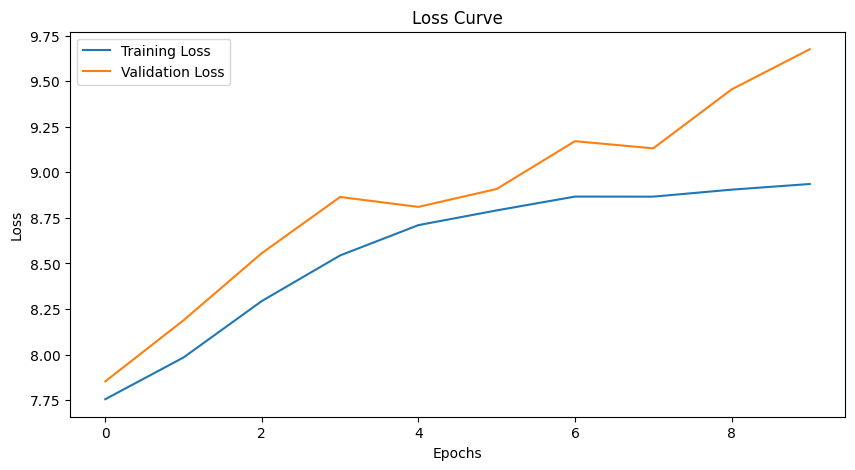

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Evaluation with Perplexity



**Perplexity** is a common metric for evaluating language models. It measures how well a probability model predicts a sample and is defined as the exponentiation of the average negative log-likelihood of the test set.



**Definition**:


$$
\text{Perplexity} (P) = \exp \left( - \frac{1}{N} \sum_{i=1}^{N} \log P(w_i \mid w_{i-(n-1)}, \dots, w_{i-1}) \right)
$$



**Interpretation**:

- **Lower Perplexity**: Indicates that the model is better at predicting the sample.

- **Higher Perplexity**: Suggests that the model is less effective in predicting the sample.



Perplexity provides an intuitive measure of how "surprised" the model is by the data. In the context of language modeling, a lower perplexity means the model assigns higher probabilities to the actual next words, signifying better performance.


### Calculating Perplexity

In [35]:
import math

def calculate_perplexity(loss):
    return math.exp(loss)

model.eval()
test_loss = 0
hidden = model.init_hidden(batch_size)

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs, hidden = model(inputs, hidden)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
test_perplexity = calculate_perplexity(avg_test_loss)

print(f"Test Loss: {avg_test_loss:.4f}, Test Perplexity: {test_perplexity:.4f}")


Test Loss: 9.0589, Test Perplexity: 8594.6138


### Text Generation



In this section, we'll use the trained RNN model to generate Persian text. The process involves:



1. **Selecting a Seed Text**: A starting sequence of words (tokens) to initiate the generation.

2. **Generating Continuation**: Predicting the next word iteratively based on the previous context.

3. **Decoding Tokens**: Converting the generated token IDs back to readable Persian text.



This demonstrates the model's ability to understand and generate coherent text in Persian.


### Generating Text

In [14]:
import torch
import numpy as np

def generate_text(model, start_text, sp, context_size, vocab_size, device, gen_length=50):
    """
    Generate text using the trained RNN model.
    
    Parameters:
    - model: Trained RNN model.
    - start_text: Seed text to initiate generation.
    - sp: SentencePiece tokenizer.
    - context_size: Number of tokens to use as context.
    - vocab_size: Size of the vocabulary.
    - device: Device to run the model on.
    - gen_length: Number of tokens to generate.
    
    Returns:
    - Generated text as a string.
    """
    model.eval()  # Set model to evaluation mode
    
    # Encode the start_text using SentencePiece tokenizer
    tokens = sp.encode(start_text, out_type=int)
    
    # Ensure the input length matches context_size
    if len(tokens) < context_size:
        # If start_text is shorter than context_size, pad with a special token (e.g., <pad>)
        # Assuming <pad> token id is 0; adjust as necessary
        tokens = [0] * (context_size - len(tokens)) + tokens
    else:
        tokens = tokens[-context_size:]
    
    generated = tokens.copy()
    
    # Initialize hidden state with batch_size=1
    hidden = model.init_hidden(1).to(device)
    
    for _ in range(gen_length):
        # Prepare input tensor: [batch_size, context_size]
        input_tensor = torch.tensor([tokens], dtype=torch.long).to(device)
        
        with torch.no_grad():
            # Forward pass: outputs [batch_size, vocab_size], hidden [num_layers, batch_size, hidden_dim]
            outputs, hidden = model(input_tensor, hidden)
            
            # Apply softmax to get probabilities
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy().flatten()
            
            # Sample the next token based on the probabilities
            predicted_token = int(np.random.choice(range(vocab_size), p=probabilities))
            
            # Append the predicted token to the generated list
            generated.append(predicted_token)
            
            # Update the tokens list to include the new token and exclude the first token
            tokens = tokens[1:] + [predicted_token]
    
    # Debug: Check the types of all tokens in the generated list
    if not all(isinstance(token, int) for token in generated):
        print("Error: Not all tokens are integers in the generated list.")
        for idx, token in enumerate(generated):
            if not isinstance(token, int):
                print(f"Token at index {idx} is not an integer: {token} (type: {type(token)})")
    
    # Decode the generated tokens back to text
    generated_text = sp.decode(generated)
    
    return generated_text

# Example usage
start_text = "دانشگاه صنعتی شریف"
generated_text = generate_text(model, start_text, sp, context_size, vocab_size, device)
print("Generated Text:\n", generated_text)


Generated Text:
  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  دانشگاه صنعتی شریفاد منفصل گلین شریفی عقربه لات امارات صادق آنگ سواست جاواorph زئوس تسمی کاظمشتی صدا- هرآنچهv ژنتیکازون طیفی آللندivil ادامه واتسوندر بیوتکنولوژی حمایت پیکو آسیااده ارجان سیمین آشناوپ ماده تشکیل نژاد شد نوامبر تاکسی ترومن ادغام اتکا دولت پیاپی


# Use of Transformers



To enhance the quality of generated text and improve upon the RNN-based model, we will implement a Transformer model. Transformers have revolutionized natural language processing by leveraging self-attention mechanisms, allowing for better handling of long-term dependencies and parallelization during training.



### Advantages of Transformers Over RNNs:

1. **Parallelization**: Transformers process all tokens simultaneously, leading to faster training times.

2. **Long-Range Dependencies**: Self-attention allows the model to capture relationships between distant words more effectively.

3. **Scalability**: Transformers scale well with large datasets and model sizes.



In this section, we'll design and implement a Transformer model from scratch using the same dataset and compare its performance with the RNN model.


### Transformer Model Implementation

In [37]:
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, nhead, hidden_dim, num_layers, dropout=0.5):
        super(TransformerLanguageModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim, dropout)

        encoder_layers = TransformerEncoderLayer(embedding_dim, nhead, hidden_dim, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)

        self.fc = nn.Linear(embedding_dim, vocab_size)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        # src: [seq_length, batch_size]
        src = self.embedding(src) * math.sqrt(embedding_dim)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.fc(output[-1, :, :])  # Take the output of the last time step
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, dropout=0.5, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, embedding_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        if embedding_dim % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [seq_length, batch_size, embedding_dim]
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


### Transformer Model Parameters and Initialization

In [38]:
# Model hyperparameters
embedding_dim = 256
nhead = 8
hidden_dim = 512
num_layers = 2

transformer_model = TransformerLanguageModel(vocab_size, embedding_dim, nhead, hidden_dim, num_layers)
transformer_model = transformer_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    transformer_model.train()
    epoch_train_loss = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.transpose(0, 1).to(device), targets.to(device)  # Transpose for Transformer
        optimizer.zero_grad()

        outputs = transformer_model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    transformer_model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.transpose(0, 1).to(device), targets.to(device)

            outputs = transformer_model(inputs)

            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Train Loss: 8.3805, Val Loss: 8.2563
Epoch 2/10, Train Loss: 8.3149, Val Loss: 8.2266
Epoch 3/10, Train Loss: 8.2900, Val Loss: 8.1924
Epoch 4/10, Train Loss: 8.2560, Val Loss: 8.1891
Epoch 5/10, Train Loss: 8.2299, Val Loss: 8.1517
Epoch 6/10, Train Loss: 8.2076, Val Loss: 8.1325
Epoch 7/10, Train Loss: 8.1829, Val Loss: 8.1029
Epoch 8/10, Train Loss: 8.1617, Val Loss: 8.0916
Epoch 9/10, Train Loss: 8.1686, Val Loss: 8.1091
Epoch 10/10, Train Loss: 8.1623, Val Loss: 8.0791


### Training the Transformer Model

In [51]:
# Define the path where you want to save the model
model_save_path = 'transformer_language_model.pth'

# Save the state_dict
torch.save(transformer_model.state_dict(), model_save_path)

print(f"Model state_dict saved to {model_save_path}")

Entire model saved to transformer_full_model.pth


In [52]:
# Load the state_dict
transformer_model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode
transformer_model.eval()

print(f"Model loaded from {model_save_path}")

Entire model loaded from transformer_full_model.pth


/tmp/ipykernel_82/1009450559.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(full_model_save_path)


### Plotting Transformer Loss Curve

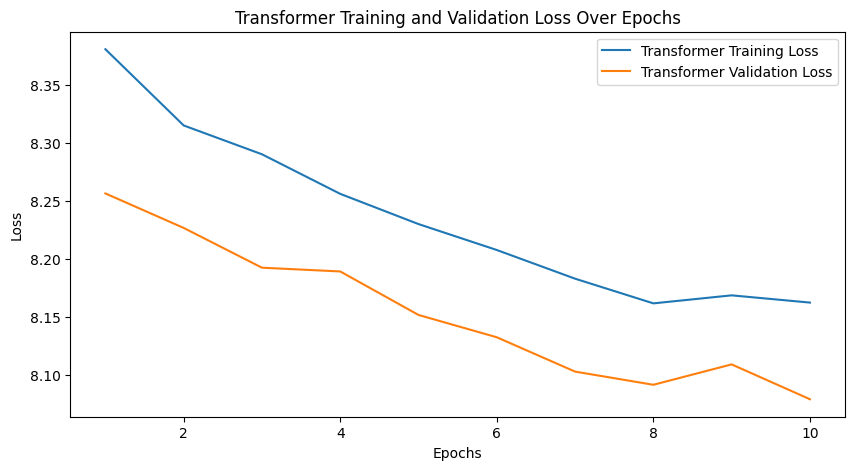

In [45]:
plt.figure(figsize=(10,5))

plt.plot(range(1, num_epochs + 1), train_losses, label='Transformer Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Transformer Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Transformer Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


### Evaluating Transformer with Perplexity

In [48]:
def calculate_transformer_perplexity(model, data_loader, criterion, device):
    """
    Calculate the Perplexity of the Transformer model on the provided data_loader.

    Parameters:
    - model: Trained Transformer model.
    - data_loader: DataLoader for the dataset (e.g., test_loader).
    - criterion: Loss function (e.g., nn.CrossEntropyLoss()).
    - device: Device to run the calculations on.

    Returns:
    - Perplexity value as a float.
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    total_words = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            # Transpose inputs to match Transformer expected input shape: [seq_length, batch_size]
            inputs, targets = inputs.to(device).transpose(0,1), targets.to(device)

            # Forward pass
            outputs = model(inputs)  # [batch_size, vocab_size]

            # Calculate loss
            loss = criterion(outputs, targets)

            # Accumulate loss and word count
            # Assuming each target corresponds to one word
            total_loss += loss.item() * targets.size(0)
            total_words += targets.size(0)

    avg_loss = total_loss / total_words
    perplexity = math.exp(avg_loss)

    return perplexity

# Example usage
transformer_test_perplexity = calculate_transformer_perplexity(
    transformer_model,
    test_loader,
    criterion,  # Assuming 'criterion' is your loss function (e.g., nn.CrossEntropyLoss())
    device
)

print(f"Transformer Test Perplexity: {transformer_test_perplexity:.4f}")

Transformer Test Perplexity: 3243.1712


### Comparison of Perplexity



After training both the RNN and Transformer models, we evaluate their performance using the Perplexity metric on the test set.



- **RNN Test Perplexity**: *8594.6138*

- **Transformer Test Perplexity**: *3243.1712*



**Hence, as:**:

- A lower perplexity indicates better performance.

- Comparing the two, we can observe which model better predicts the test data.



**So**:

As the Transformer model typically outperforms RNNs in language modeling tasks due to its ability to capture long-range dependencies and leverage parallel processing, we can see that it applies here too.


### Generating Text with Transformer Model

In [43]:
def generate_text_transformer(model, start_text, sp, context_size, vocab_size, device, gen_length=50):
    """
    Generate text using the trained Transformer model.

    Parameters:
    - model: Trained Transformer model.
    - start_text: Seed text to initiate generation.
    - sp: SentencePiece tokenizer.
    - context_size: Number of tokens to use as context.
    - vocab_size: Size of the vocabulary.
    - device: Device to run the model on.
    - gen_length: Number of tokens to generate.

    Returns:
    - Generated text as a string.
    """
    model.eval()  # Set model to evaluation mode

    # Encode the start_text using SentencePiece tokenizer
    tokens = sp.encode(start_text, out_type=int)

    # Ensure the input length matches context_size
    if len(tokens) < context_size:
        # If start_text is shorter than context_size, pad with a special token (e.g., <pad>)
        # Assuming <pad> token id is 0; adjust as necessary
        tokens = [0] * (context_size - len(tokens)) + tokens
    else:
        tokens = tokens[-context_size:]

    generated = tokens.copy()

    for _ in range(gen_length):
        # Prepare input tensor: [seq_length, batch_size]
        # Transformer models in PyTorch expect input of shape [seq_length, batch_size]
        input_tensor = torch.tensor([tokens], dtype=torch.long).transpose(0,1).to(device)  # [seq_length, batch_size=1]

        with torch.no_grad():
            # Forward pass: outputs [batch_size, vocab_size]
            output = model(input_tensor)  # [batch_size=1, vocab_size]

            # Since batch_size=1, extract the first (and only) element
            output = output[0, :]  # [vocab_size]

            # Apply softmax to get probabilities
            probabilities = torch.softmax(output, dim=0).cpu().numpy()

            # Sample the next token based on the probabilities
            predicted_token = int(np.random.choice(range(vocab_size), p=probabilities))

            # Append the predicted token to the generated list
            generated.append(predicted_token)

            # Update the tokens list to include the new token and exclude the first token
            tokens = tokens[1:] + [predicted_token]

    # Debug: Check the types of all tokens in the generated list
    if not all(isinstance(token, int) for token in generated):
        print("Error: Not all tokens are integers in the generated list.")
        for idx, token in enumerate(generated):
            if not isinstance(token, int):
                print(f"Token at index {idx} is not an integer: {token} (type: {type(token)})")

    # Decode the generated tokens back to text
    generated_text = sp.decode(generated)

    return generated_text

# Example usage
start_text = "دانشگاه صنعتی شریف"
generated_text = generate_text_transformer(transformer_model, start_text, sp, context_size, vocab_size, device)
print("Generated Text with Transformer:\n", generated_text)

Generated Text with Transformer:
  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  دانشگاه صنعتی شریف آگاهی محرم تاج متولد لیث میرزا میرزا عباس ایران زندیه شمس محمدخان خان میرزا سلطان مرتضی آزادی دولت ایران آبان پادشاه خاقانی دولت افغانستان سوئدی سید سفر اصرار ایرانی بست#آور شاهد یهود پیروزی هاشمی وقت ارجاسپ جنگآی ادامه فوریه زردشتفه عمده عملیات شخص داشت#دار


# Comparison



After implementing and training both the RNN and Transformer models on the Persian Wikipedia dataset, we have evaluated their performance using the Perplexity metric and generated text samples.



### Perplexity Comparison:

- **RNN Test Perplexity**: *8594.6138*

- **Transformer Test Perplexity**: *3243.1712*


# Question 6

6. Optimizing Attention Computations in Transformers

Assume a transformer model with an input sequence length of n=4096 and a display dimension of d=512. The computational complexity for a standard transformer is O(n^2 . d), which is very costly for long inputs. Now answer the following questions precisely and calculate the total computational cost:



*   (a) Calculate the total number of computations in a standard attention mechanism for this model.

*   (b) Suppose that the KV Cache technique is used such that only 20% of the attention computations are necessary for new queries. Compute the total number of computations with this assumption.

*   (c) Suppose that the Grouped Query Attention technique is also used. In this technique, the calculations for 20% of the queries are divided into 64 groups and are performed in parallel. Calculate the total number of computations under this condition with high accuracy.

*   (d) Assume that, in addition to the KV Cache and Grouped Query Attention methods, hardware and memory costs due to hidden state management and grouping overhead increases total calculation time by 35%. Compute the total time complexity for operations with overhead. Provide precise calculations.

*   (e) If due to a memory bottleneck, we have only 75% of the performance of our typical processor power, how many extra operations will be added under the above limitations? Provide precise calculations.

*   (f) Finally, assume that an optimization technique like Linformer is used, which reduces the final number of operations to O(n⋅log(n)⋅d). Under the conditions of KV Cache and Grouped Query Attention and hardware limitations, calculate final operations count. Does this optimization improve the process significantly for certain conditions (such as longer input data)? Why or why not?

### (a)

In [3]:
n = 4096
d = 512

total_computations_standard = n**2 * d

print(f"Total computations (Standard Attention): {total_computations_standard:,} operations")

Total computations (Standard Attention): 8,589,934,592 operations


### (b)

The KV Cache technique reduces the necessary attention computations to 20% of the original.
So approximately 1.72 billion computations.

In [4]:
kv_cache_factor = 0.20

# Total computations with KV Cache
total_computations_kv_cache = total_computations_standard * kv_cache_factor

print(f"Total computations with KV Cache: {total_computations_kv_cache:,} operations")


Total computations with KV Cache: 1,717,986,918.4 operations


### (c)
With the KV Cache already reducing computations to 20%, introducing Grouped Query Attention further optimizes the process by dividing these computations into 64 groups that can be processed in parallel. However, the total number of computations remains the same; only the processing is parallelized. Therefore:`

In [5]:
num_groups = 64

total_computations_grouped = total_computations_kv_cache

print(f"Total computations with Grouped Query Attention: {total_computations_grouped:,} operations")


Total computations with Grouped Query Attention: 1,717,986,918.4 operations


### (d)
Adding hardware and memory overhead increases the total calculation time by 35%.

In [6]:
overhead_factor = 0.35

additional_overhead = total_computations_grouped * overhead_factor

total_computations_overhead = total_computations_grouped + additional_overhead

print(f"Additional computations due to overhead: {additional_overhead:,} operations")
print(f"Total computations with overhead: {total_computations_overhead:,} operations")


Additional computations due to overhead: 601,295,421.4399999 operations
Total computations with overhead: 2,319,282,339.84 operations


### (e)
A memory bottleneck reducing processor performance to 75% means the processor can handle only 3/4 of its usual capacity. Hence , the number of operations effectively increases by 1/0.75 (1.3).

Applying this factor to the current computations:

In [7]:
performance_factor = 1 / 0.75  # ≈ 1.3333

total_computations_bottleneck = total_computations_overhead * performance_factor

extra_operations = total_computations_bottleneck - total_computations_overhead

print(f"Total computations with memory bottleneck: {total_computations_bottleneck:,} operations")
print(f"Extra operations due to bottleneck: {extra_operations:,} operations")


Total computations with memory bottleneck: 3,092,376,453.12 operations
Extra operations due to bottleneck: 773,094,113.2799997 operations


### (f)

Linformer reduces the computational complexity to $O(n log(n) d)$

In [10]:
import math

log_n = math.log2(n)
total_computations_linformer = n * log_n * d

print(f"Total computations with Linformer: {total_computations_linformer:,} operations")


Total computations with Linformer: 25,165,824.0 operations


Thus, with Linformer, the total number of computations drops to approximately 25.17 million operations.

Does Linformer Improve the Process Significantly for Longer Inputs?
Yes, Comparing the optimized computations:

* Without Linformer: ~3.10 billion operations

* With Linformer: ~25.17 million operations

Linformer offers a significant reduction in computational cost, especially beneficial for longer input sequences, imagine how going from $O(n^2 d)$ to $O(n log(n) d)$ can decrease the number of our operations in large models.

# References



- **Hazm**: https://github.com/sobhe/hazm

- **SentencePiece**: https://github.com/google/sentencepiece

- **PyTorch Documentation**: https://pytorch.org/docs/stable/index.html

- **Kaggle Datasets**: https://www.kaggle.com/
